In [1]:
import math

import pandas as pd

import analysis
import distributions
from pacing import AdServer, Auction, Campaign, AsapPacing, CumulativeEqualPacing, RecomputedEqualPacing, LinkedInPacing
from simulation import Simulation

In [2]:
# general settings
num_campaigns = 10
impressions_target = 1000

impressions = math.ceil(num_campaigns * impressions_target)

ticks = 24 * 60

base_dist = distributions.custom_dist(ticks)
# base_dist = distributions.uniform_dist(ticks)
traffic_dist = distributions.traffic_distribution(base_dist, impressions)

In [3]:
asap = [Campaign(i, i, AsapPacing(i * impressions_target)) for i in range(1, num_campaigns + 1)]
cumulative_equal = [Campaign(i, i, CumulativeEqualPacing(i * impressions_target, ticks)) for i in
                    range(1, num_campaigns + 1)]
recomputed_equal = [Campaign(i, i, RecomputedEqualPacing(i * impressions_target, ticks)) for i in
                    range(1, num_campaigns + 1)]
linkedin = [Campaign(i, i, LinkedInPacing(i * impressions_target, traffic_dist)) for i in range(1, num_campaigns + 1)]
linkedin_hot_end = [Campaign(i, i, LinkedInPacing(i * impressions_target,
                                                  distributions.traffic_distribution(base_dist, impressions_target),
                                                  2 * 60)) for i in range(1, num_campaigns + 1)]


def configure_and_run(campaigns, traffic_distribution, ticks):
    auction = Auction(campaigns)
    ad_server = AdServer(traffic_distribution, auction, campaigns)
    sim = Simulation(ticks, ad_server)
    return sim.run()

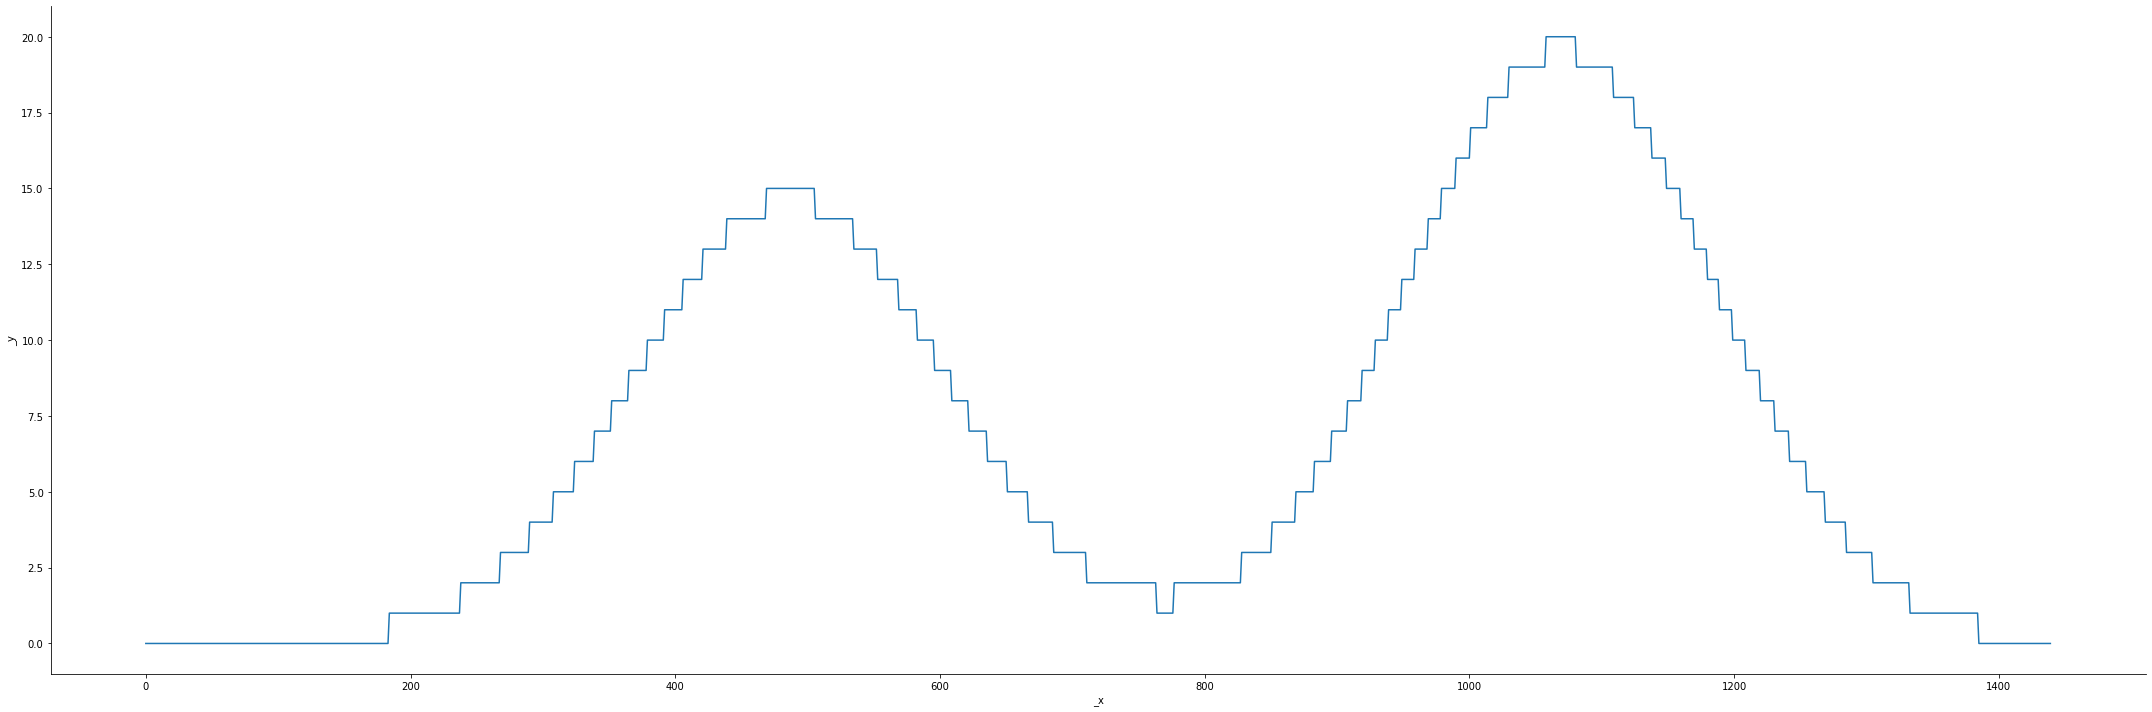

In [4]:
analysis.line_plot(traffic_dist)

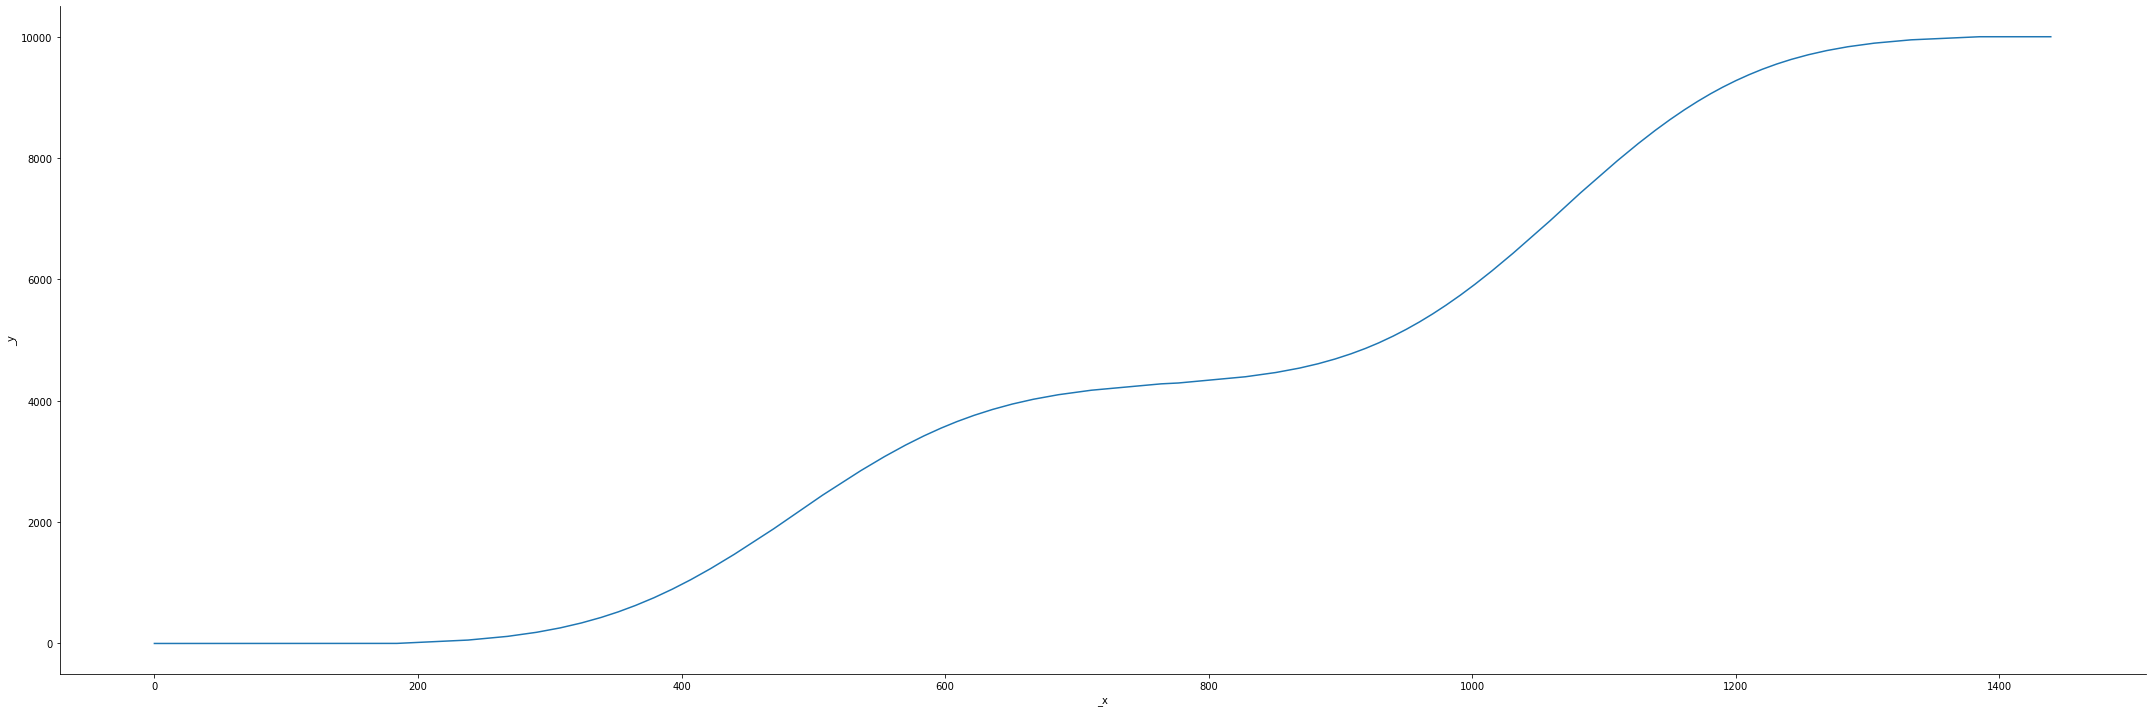

In [5]:
analysis.line_plot(traffic_dist.cumsum())

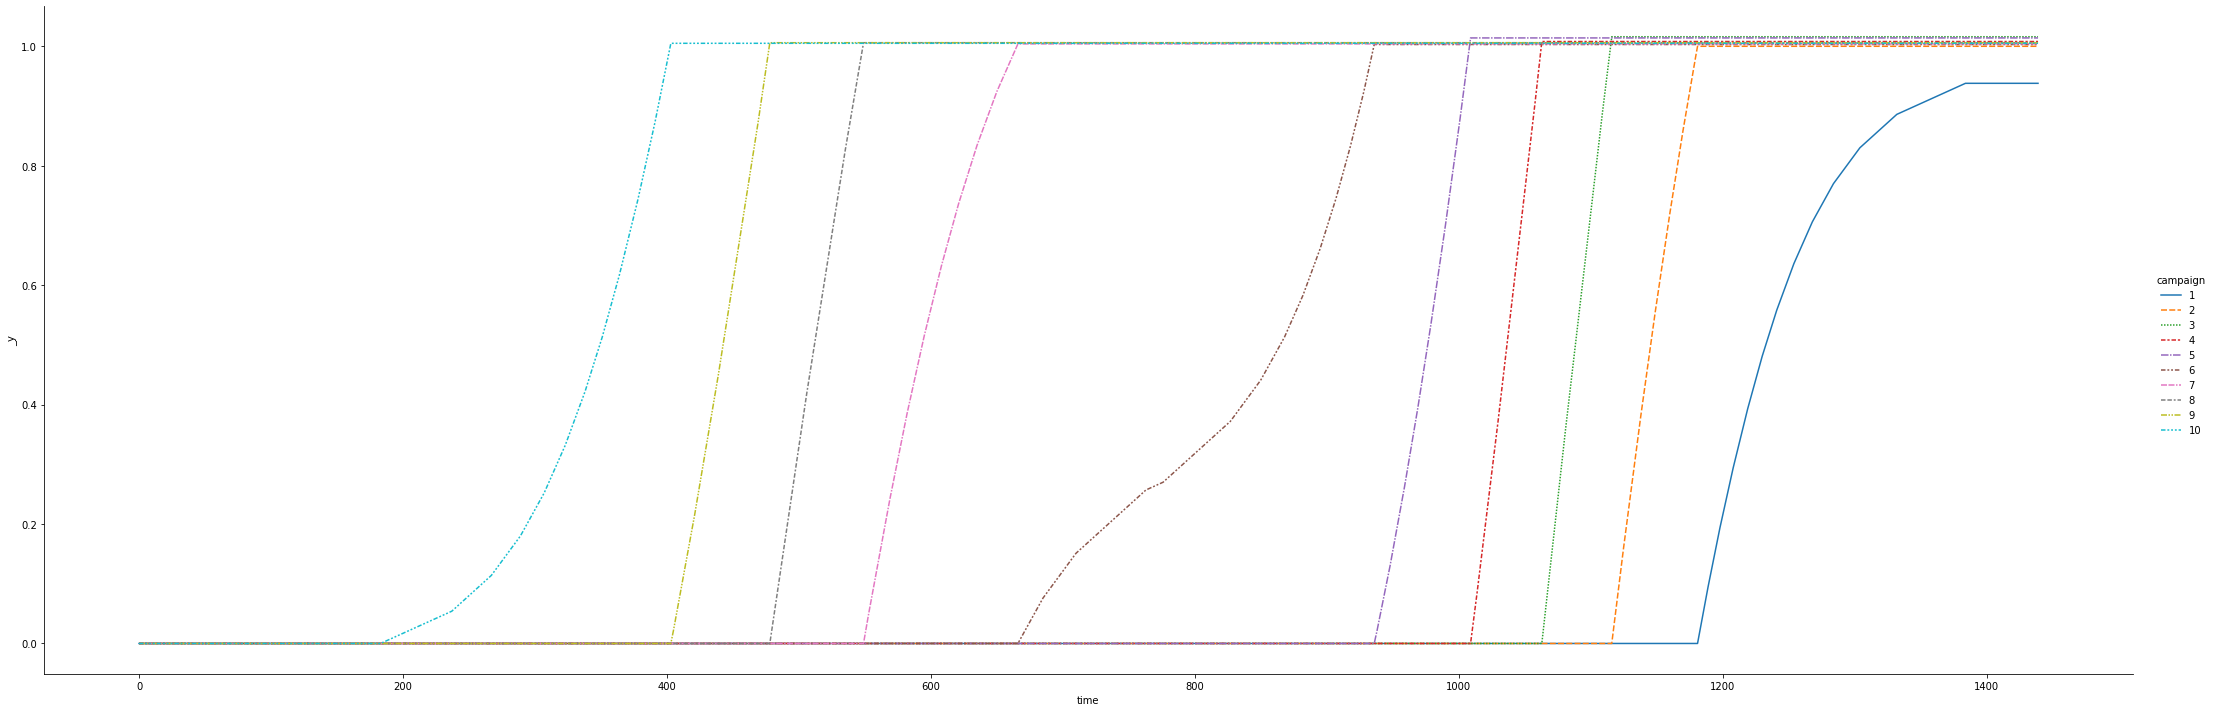

In [6]:
evs = configure_and_run(asap, traffic_dist, ticks)
analysis.analyse(evs, asap, ticks)
stats_asap = analysis.stats(evs)

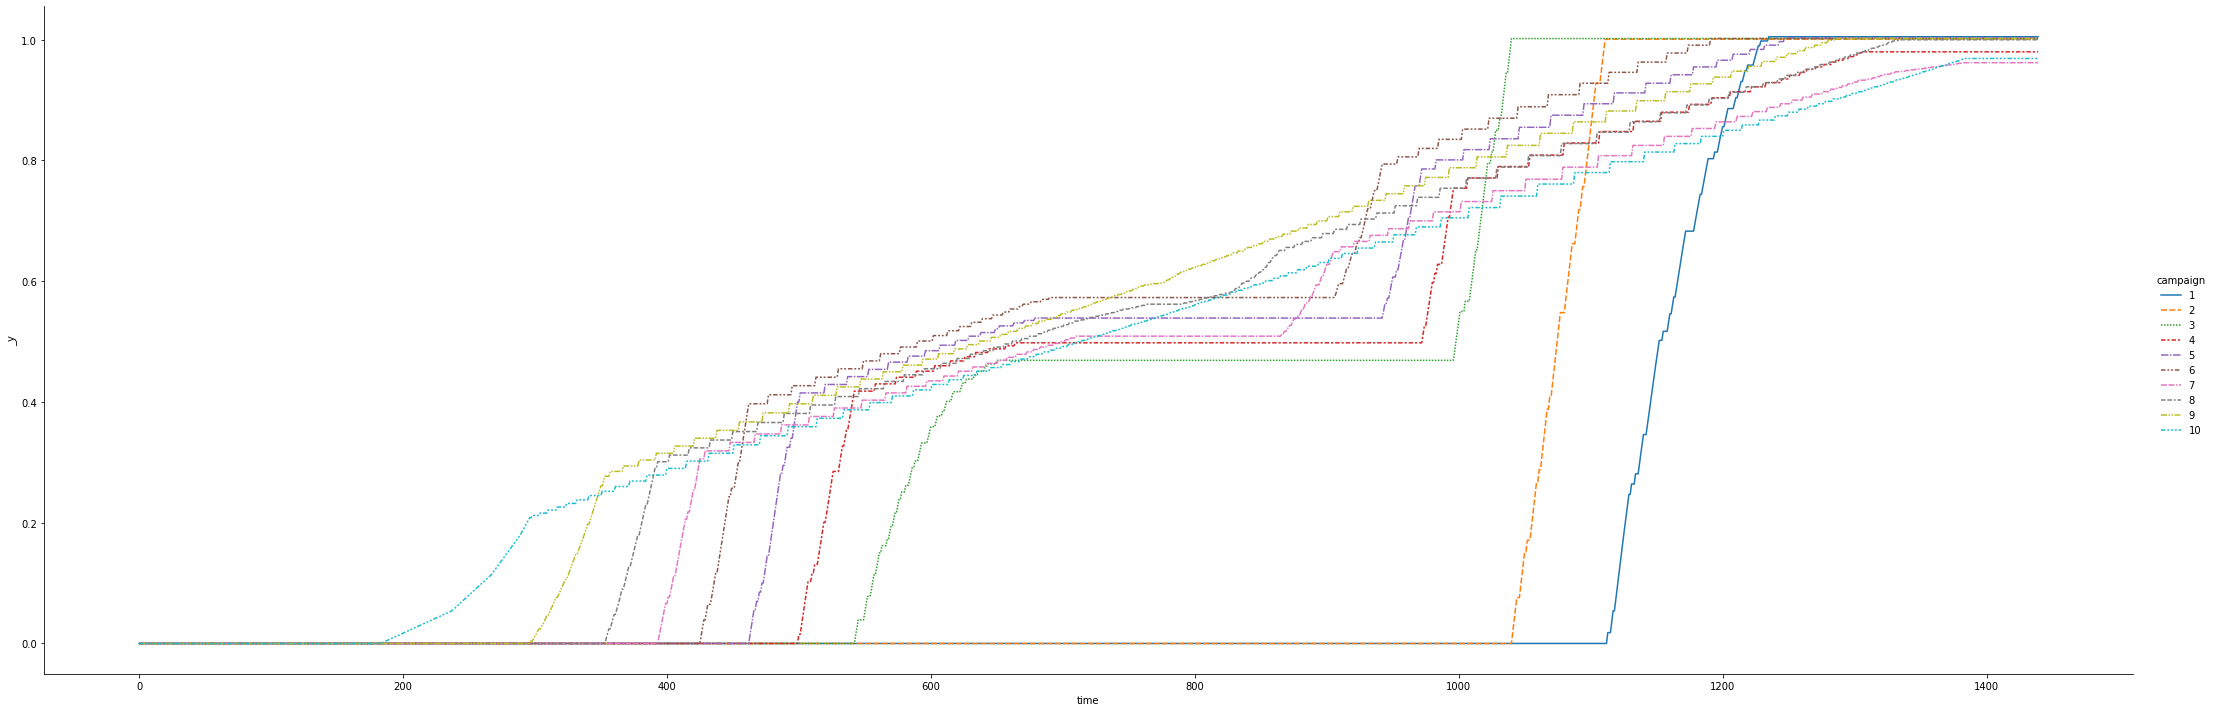

In [7]:
evs = configure_and_run(cumulative_equal, traffic_dist, ticks)
analysis.analyse(evs, cumulative_equal, ticks)
stats_cum_eq = analysis.stats(evs)

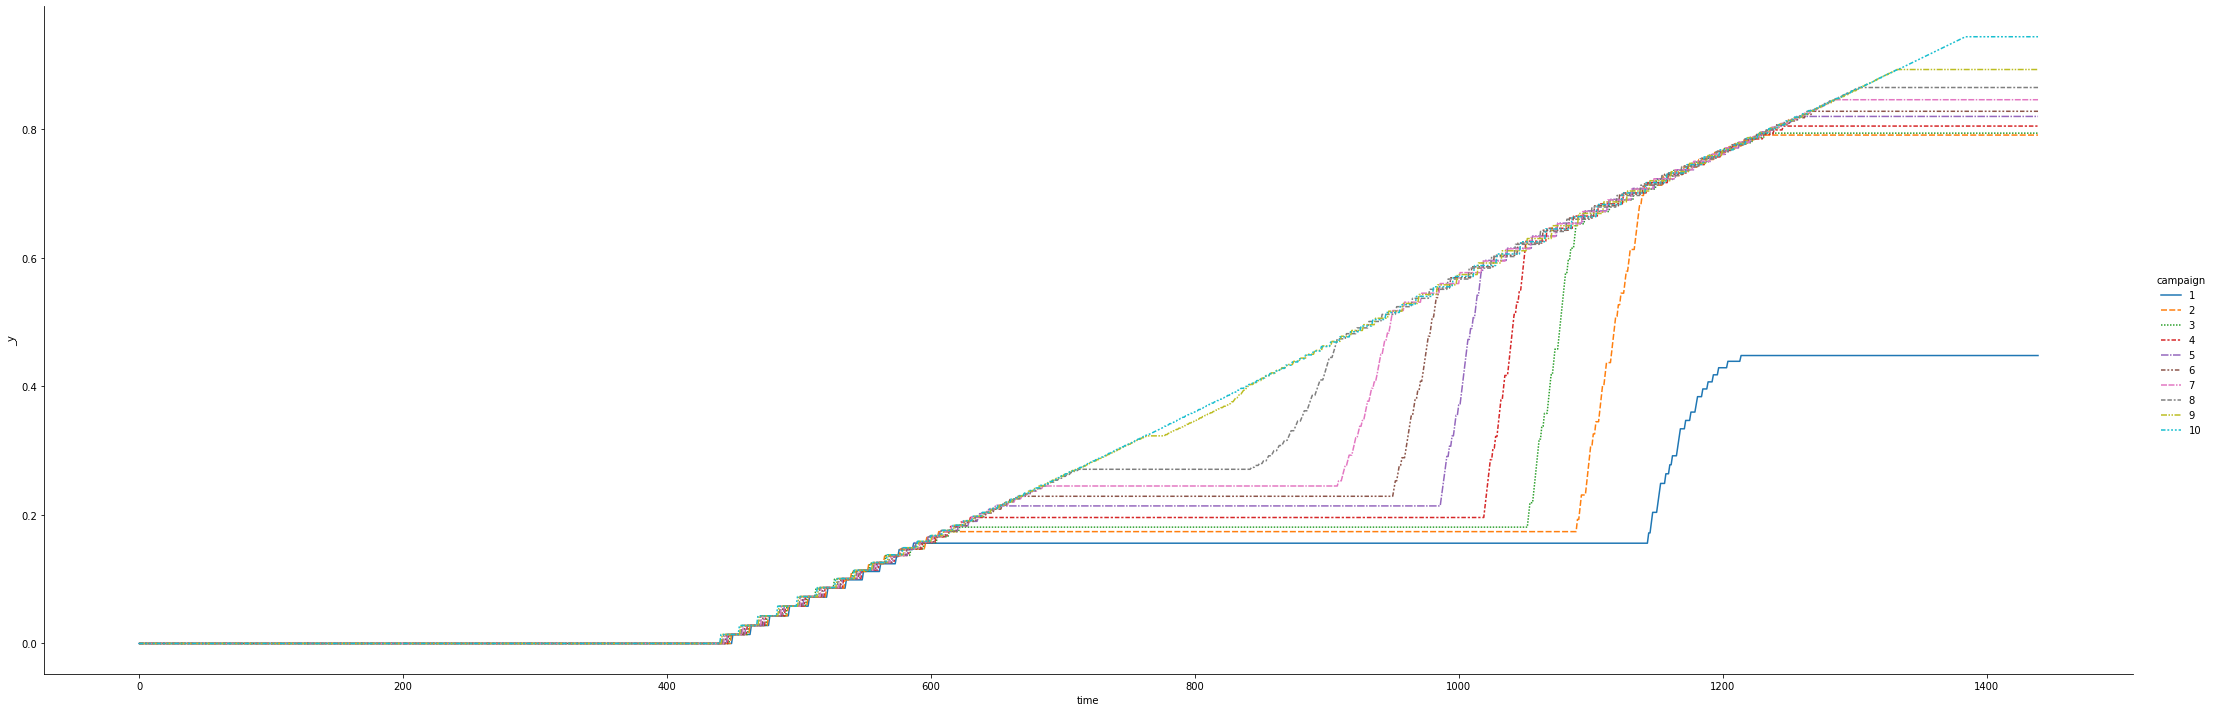

In [8]:
evs = configure_and_run(recomputed_equal, traffic_dist, ticks)
analysis.analyse(evs, recomputed_equal, ticks)
stats_re_eq = analysis.stats(evs)

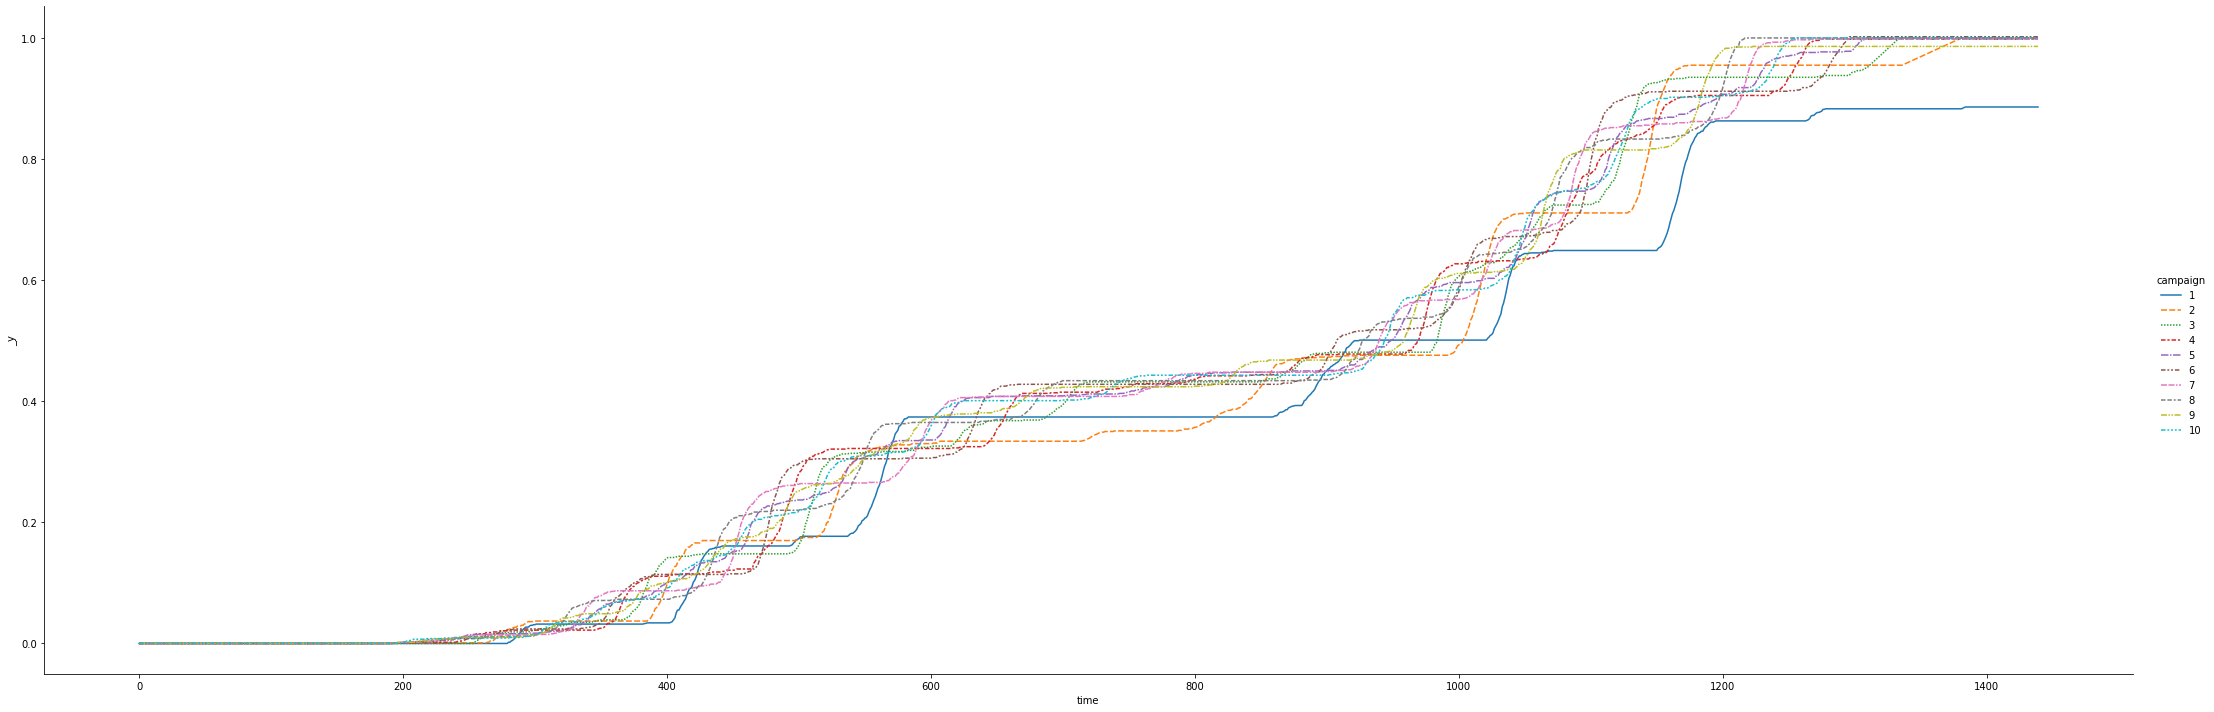

In [9]:
evs = configure_and_run(linkedin, traffic_dist, ticks)
analysis.analyse(evs, linkedin, ticks)
stats_lin = analysis.stats(evs)

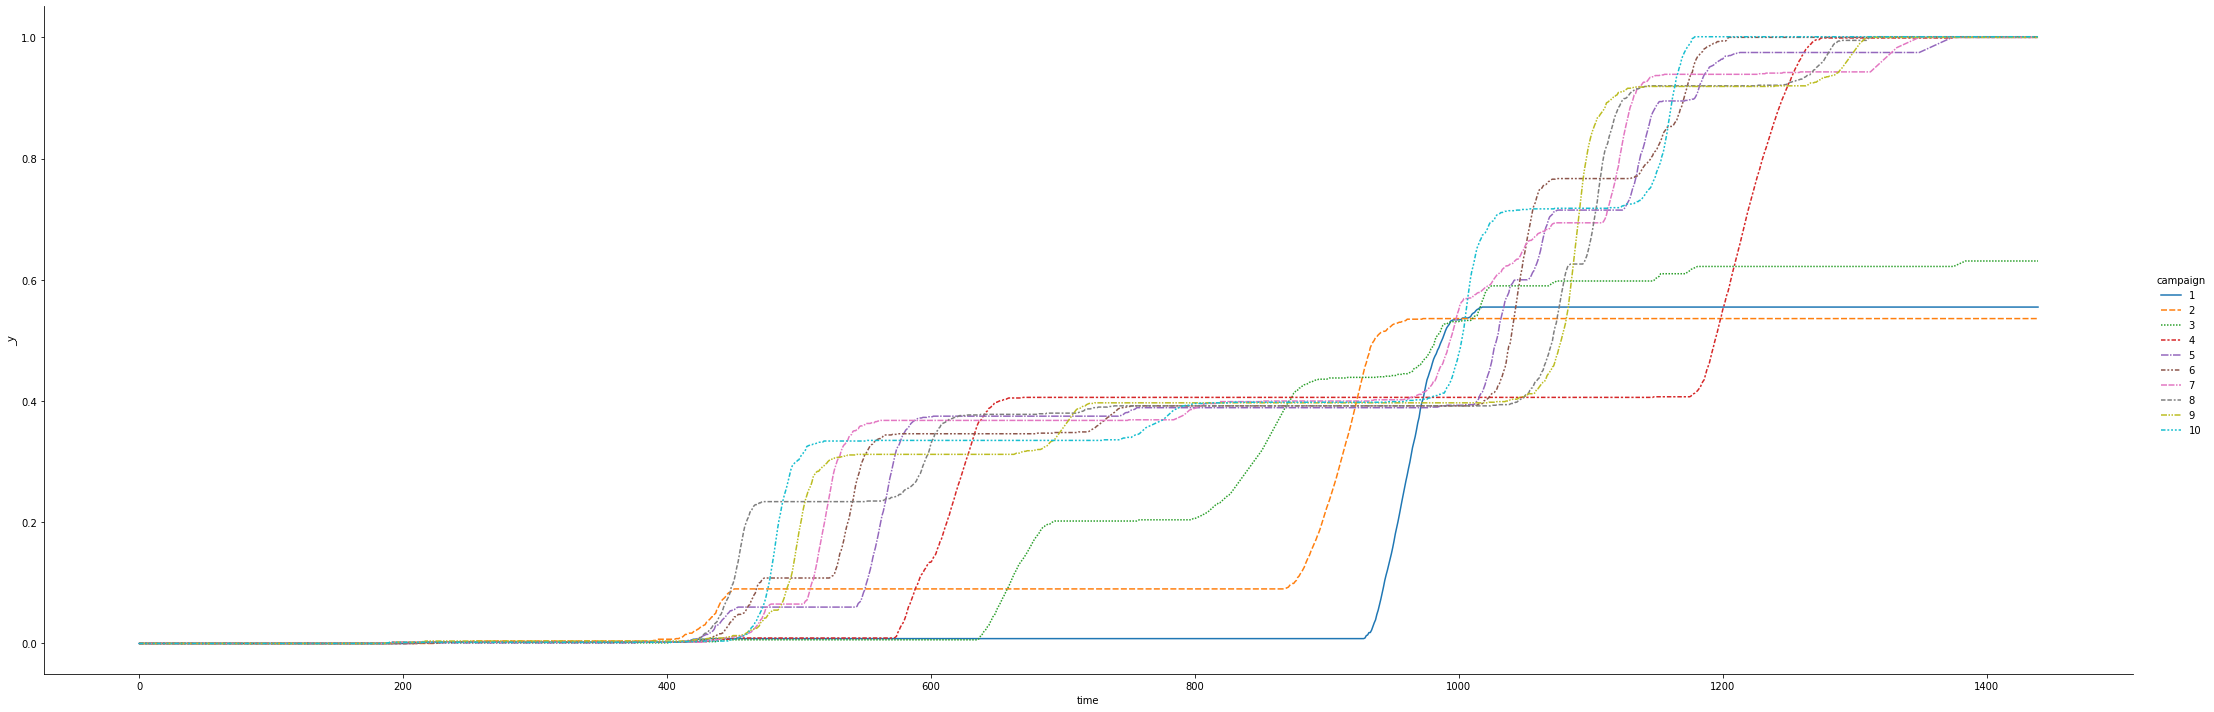

In [10]:
evs = configure_and_run(linkedin_hot_end, traffic_dist, ticks)
analysis.analyse(evs, linkedin_hot_end, ticks)
stats_lin_he = analysis.stats(evs)

In [11]:
ticks

1440

In [12]:
len(traffic_dist)

1440

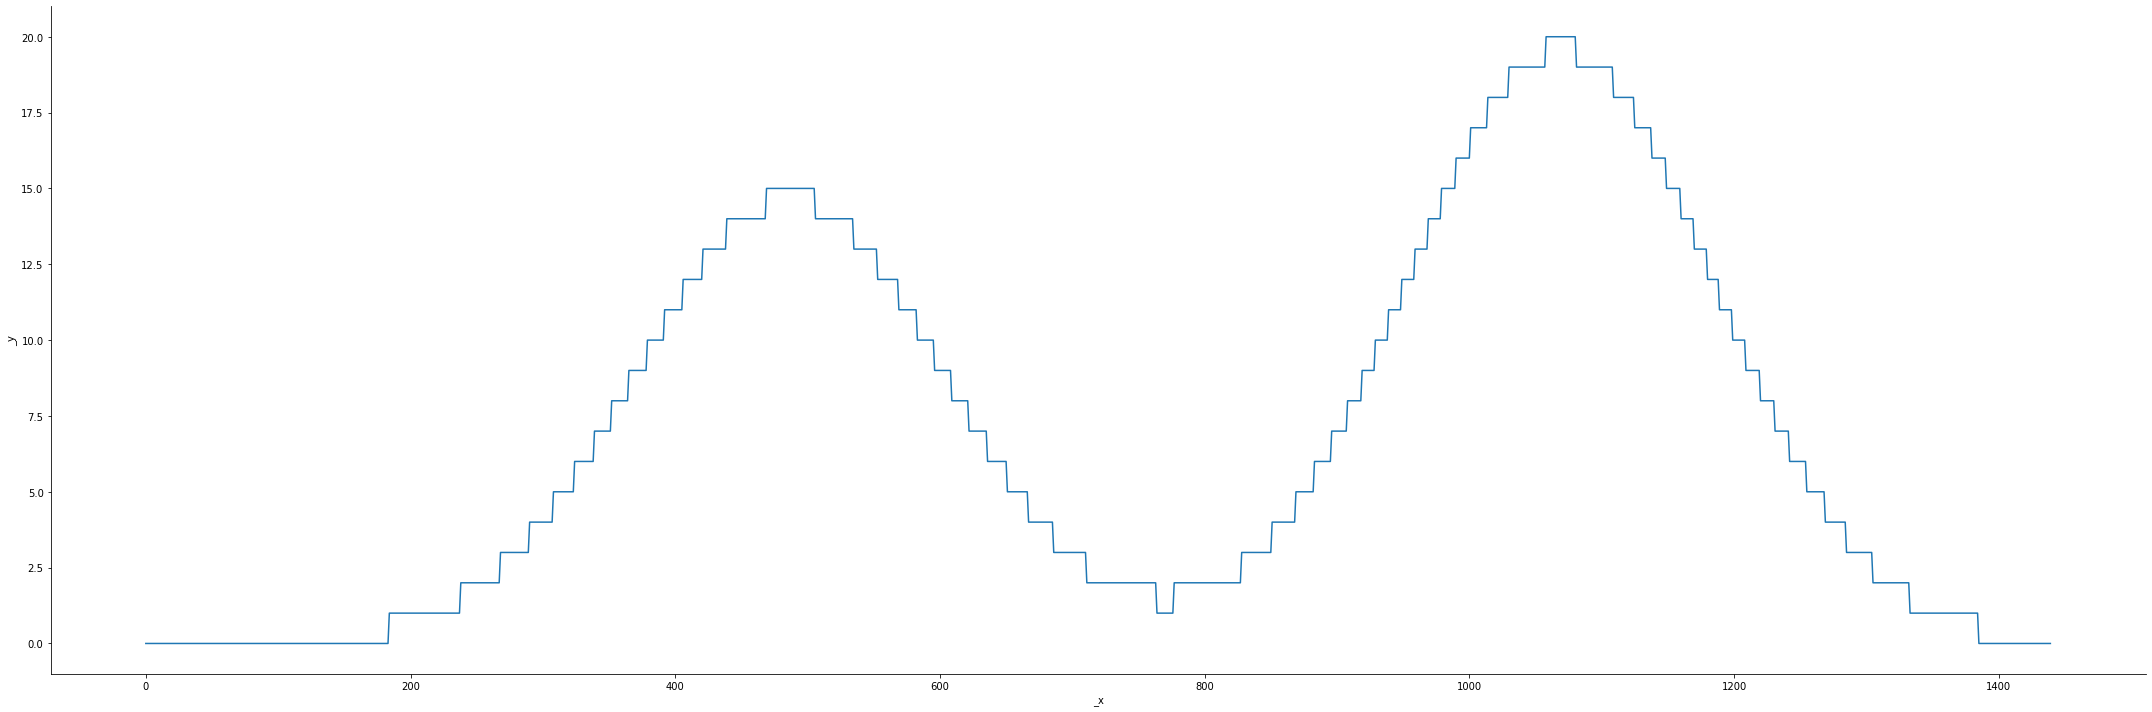

In [13]:
from analysis import line_plot

line_plot(traffic_dist)

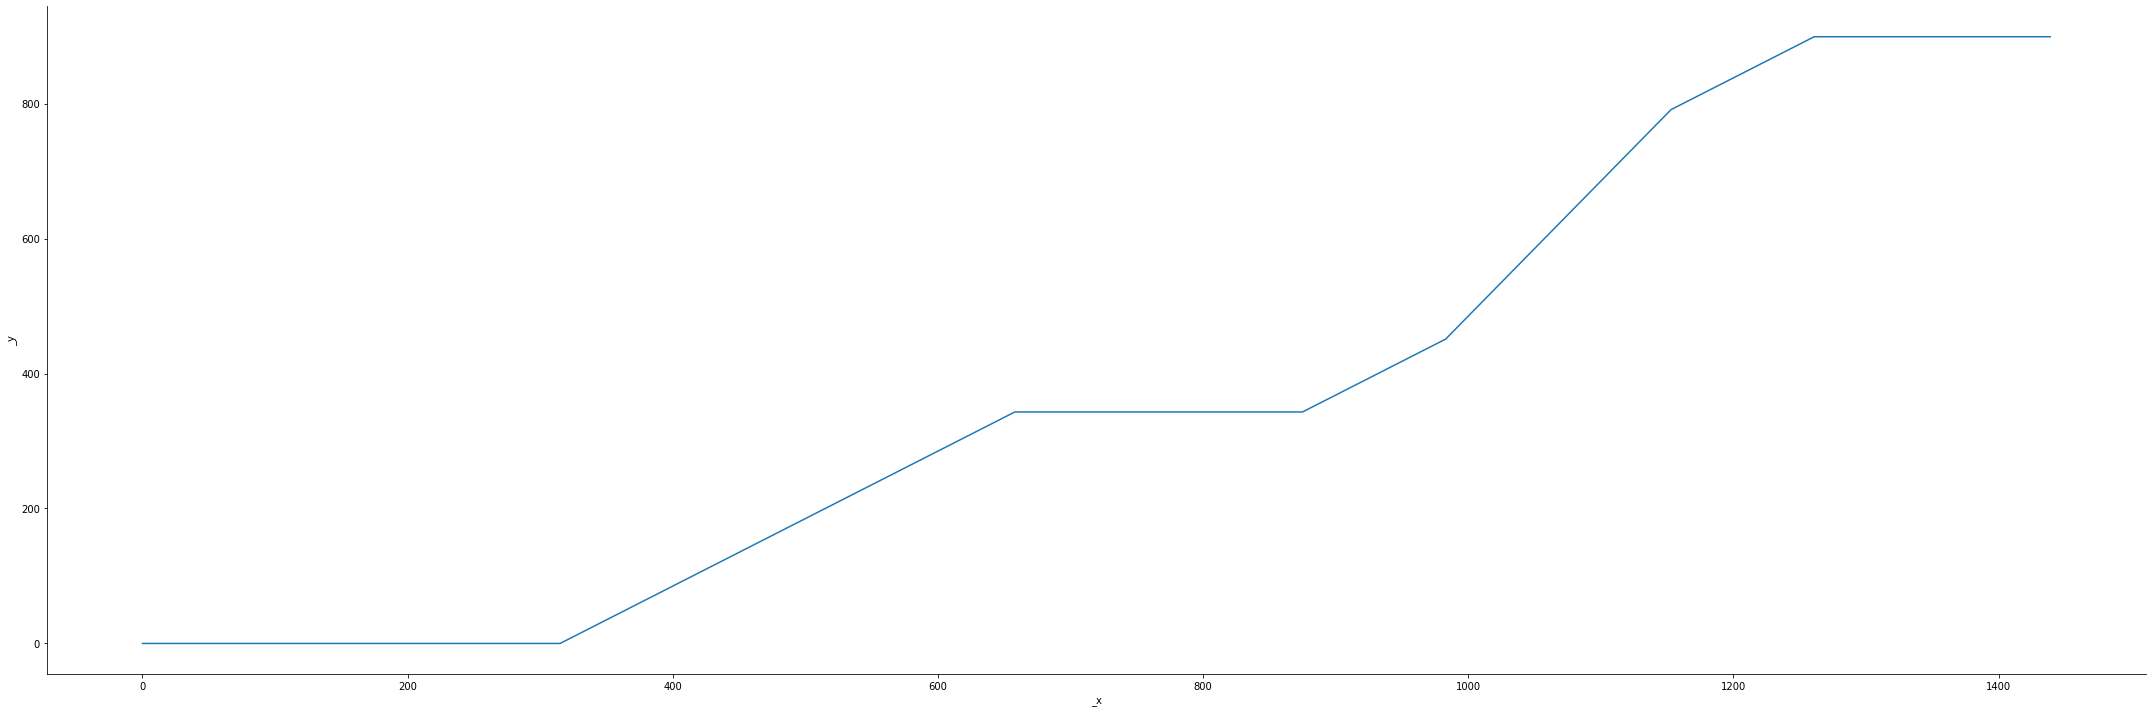

In [14]:
line_plot(linkedin_hot_end[0].pacing.forecast)

In [15]:
t_size_df = pd.DataFrame({
    "asap": stats_asap["t_size"],
    "cum_eq": stats_cum_eq["t_size"],
    "re_eq": stats_re_eq["t_size"],
    "lin": stats_lin["t_size"],
    "lin_he": stats_lin_he["t_size"],
})

In [16]:
import numpy as np

t_size_df.agg([np.mean, np.median])

,asap,cum_eq,re_eq,lin,lin_he
mean,120.1,721.1,830.0,1088.4,1047.8
median,74.0,796.0,818.5,1085.5,1112.0


In [17]:
t_uniq_df = pd.DataFrame({
    "asap": stats_asap["t_uniq"],
    "cum_eq": stats_cum_eq["t_uniq"],
    "re_eq": stats_re_eq["t_uniq"],
    "lin": stats_lin["t_uniq"],
    "lin_he": stats_lin_he["t_uniq"],
})
t_uniq_df.agg([np.mean, np.median])

,asap,cum_eq,re_eq,lin,lin_he
mean,120.1,118.8,90.8,371.2,211.5
median,74.0,84.5,65.0,365.0,237.5


In [18]:
imps_df = pd.DataFrame({
    "asap": stats_asap["imps"],
    "cum_eq": stats_cum_eq["imps"],
    "re_eq": stats_re_eq["imps"],
    "lin": stats_lin["imps"],
    "lin_he": stats_lin_he["imps"],
})
imps_df.agg([np.mean, np.median])

,asap,cum_eq,re_eq,lin,lin_he
mean,1000.0,992.6,803.4,987.0,872.4
median,1005.5,1001.5,824.0,1000.0,1000.0


In [19]:
discr = imps_df - impressions_target

In [20]:
discr.abs().agg([np.sum, np.mean, np.median, np.min, np.max])

,asap,cum_eq,re_eq,lin,lin_he
sum,124.0,104.0,1966.0,134.0,1280.0
mean,12.4,10.4,196.6,13.4,128.0
median,6.0,2.5,176.0,1.0,0.5
amin,0.0,0.0,56.0,0.0,0.0
amax,62.0,38.0,552.0,114.0,464.0


In [21]:
under = discr.copy()

In [22]:
under[under > 0] = 0

In [23]:
under

,asap,cum_eq,re_eq,lin,lin_he
campaign,,,,,
1,-62,0,-552,-114,-445
2,0,0,-209,0,-464
3,0,0,-206,0,-369
4,0,-20,-195,-2,0
5,0,0,-180,0,0
6,0,0,-172,0,0
7,0,-38,-154,-2,0
8,0,0,-135,0,0
9,0,0,-107,-14,0


In [24]:
under.agg([np.sum, np.mean, np.median])

,asap,cum_eq,re_eq,lin,lin_he
sum,-62.0,-89.0,-1966.0,-132.0,-1278.0
mean,-6.2,-8.9,-196.6,-13.2,-127.8
median,0.0,0.0,-176.0,0.0,0.0


In [25]:
over = discr.copy()

In [26]:
over[over < 0] = 0

In [27]:
over

,asap,cum_eq,re_eq,lin,lin_he
campaign,,,,,
1,0,5,0,0,0
2,0,1,0,0,0
3,16,2,0,0,0
4,8,0,0,0,0
5,14,3,0,0,0
6,3,2,0,2,0
7,4,0,0,0,0
8,6,0,0,0,1
9,6,2,0,0,0


In [28]:
over.agg([np.sum, np.mean, np.median])

,asap,cum_eq,re_eq,lin,lin_he
sum,62.0,15.0,0.0,2.0,2.0
mean,6.2,1.5,0.0,0.2,0.2
median,5.5,1.5,0.0,0.0,0.0
